# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import torch
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as f
from torchvision import datasets, models, transforms

import numpy as np

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
from collections import OrderedDict
from typing import Iterable
from collections import Counter

image_size = 277        # Standardize all images to a square of this size
num_workers = 2         # number of subprocesses to use for data loading
# batch_size = 256        # how many samples per batch to load
validation_ratio = 0.2  # percentage of training set to use as validation
image_base_dir = r'./landmark_images/'

'''
# extract images if necessary
import requests
import io
import zipfile
def download_extract_zip(url):
    # Download a ZIP file and extract its contents in memory
    # yields (filename, file-like object) pairs
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        thezip.extractall('./')
                
download_extract_zip(r'https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip')
'''

"\n# extract images if necessary\nimport requests\nimport io\nimport zipfile\ndef download_extract_zip(url):\n    # Download a ZIP file and extract its contents in memory\n    # yields (filename, file-like object) pairs\n    response = requests.get(url)\n    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:\n        thezip.extractall('./')\n                \ndownload_extract_zip(r'https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip')\n"

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# convert data to a normalized torch.FloatTensor
training_transform = transforms.Compose([
    # don't know if the images are landscape or portrate, or how the image is uploaded.
    # also don't know the purpose of the image, if it is artistic from a strange angle.
    transforms.RandomRotation(degrees=(-45,45)),
    # standardize the image size
    transforms.Resize(int(image_size*1.07)),
    transforms.CenterCrop(image_size),
    # make this a tensor (rgb,h,w)
    transforms.ToTensor()
    # The images are assumed to be in RGB of unknown color depth
    # 8 bit colors will have values between 0-255, but colors can go to 48 bit or more.
    # The normalization step will ensure that the values are in a consistent range.
    # Using a mean of 0.5 and stdev of 0.5, the normalization will result in a value between 0-1
    # since we are dealing with RGB, we need 3 or each
    # ,transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
transform = transforms.Compose([
    transforms.Resize(int(image_size*1.07)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
    # ,transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

loaders_scratch = {}
test_dataset = datasets.ImageFolder(os.path.join(image_base_dir,r'test'), transform=transform)
train_dataset = datasets.ImageFolder(os.path.join(image_base_dir,r'train'), transform=training_transform)

classes = train_dataset.classes
batch_size = int(len(classes)*1.736)
print(batch_size)

# to split the training data into training and validation data
# it is actually the indecies that are split.
# this will shuffle the indecies randomly, and then split the list based on the validation_ratio
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
split = int(len(train_dataset) * validation_ratio)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# now there can be three loaders for training, testing, and validation images. 
# here the sampler parameter accepts the list of indecies that are allowed to be returned from the loader

loaders_scratch['test'] = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
loaders_scratch['train'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
loaders_scratch['valid'] = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)

86


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

---
**Answer**: <br />
<font face = "Roboto" style="font-style:italic;" size="3 em">
* set up config parameters
* define transforms
    * training transform has a random +/- 75 degree rotation, testing does not have a totation
    * images are resized for uniformity to 224x224 (following VGG16)
    * values are normalized for uniformity
* training set is split into a training and validation set
    (It would be nice to control the rotation of all three of the image sets. I'll save that for later as time permits.)

Image resize is handled in the transform, and will result in a square image (stretching or squishing as needed.  
In the training set, images were randomly rotated 75 degrees, to handle landscape/portrate formats, 
uploading orientation errors, artistic shots from strange angles, etc.
The image is also center cropped just a bit to remove padding post rotation.
</font><br/>
---

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

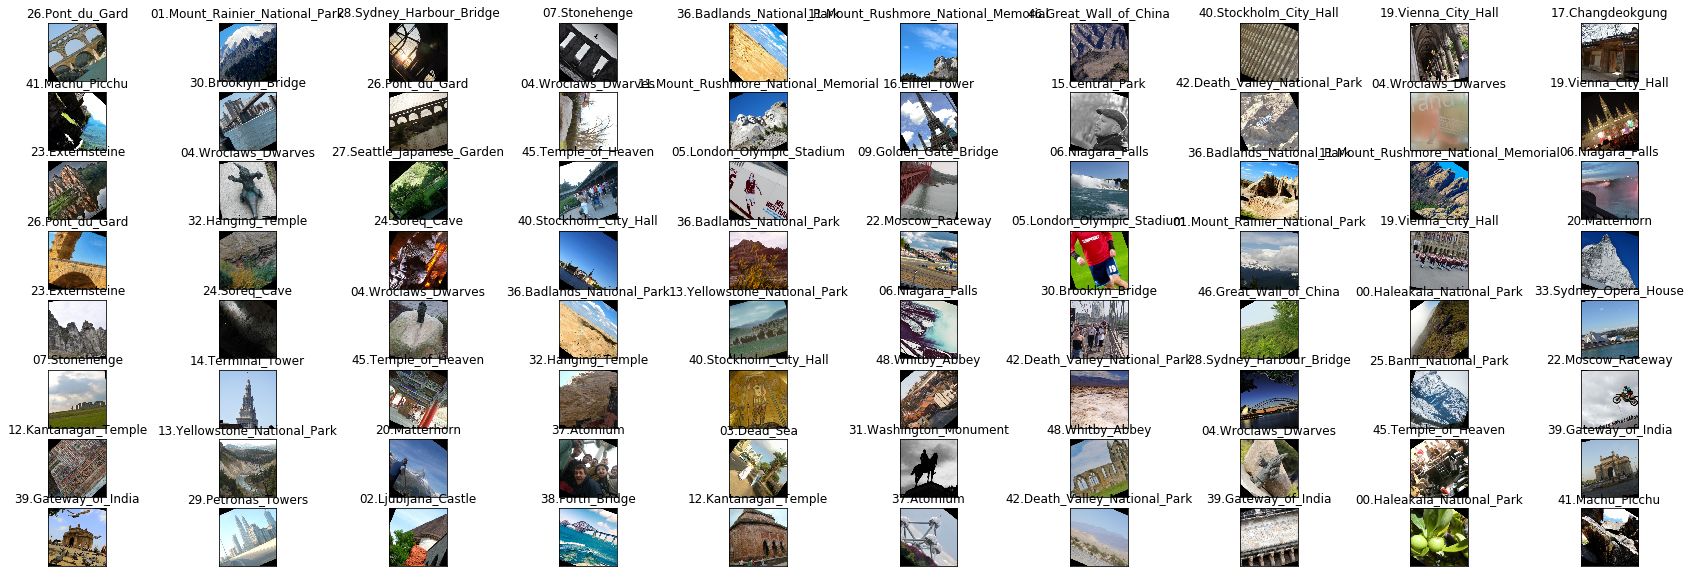

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

classes = train_dataset.classes

display_count = batch_size
cols = 10
rows = int(display_count / cols)

# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 10))
for idx in np.arange(cols*rows):
    ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

if not use_cuda: print('CUDA is not available.  Training on CPU ...')
else:            print('Training on NVidia CUDA Driver ...')

Training on NVidia CUDA Driver ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.0007)
    # return optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

---
#### CNN Advancements
<p style="text-align: center;">
<img src="https://learnopencv.com/wp-content/uploads/2019/06/Model_Timeline.png" alt="CNN Advancements"/>
Mishwesh Shrimali; PyTorch for Beginners: Image Classification using Pre-trained models<br/>
https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
<p/>
---

In [6]:
import torch.nn as nn

# define the CNN architecture
'''
    VGG16 is not used
'''
class My_VGG16(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(My_VGG16, self).__init__()
        
        ## Define layers of a CNN
        
        c01 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        c11 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        c12 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        c21 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        c22 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        c31 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        c32 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        c41 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.70, inplace=False)

        # Feature Layers
        self.features = nn.Sequential(
            # initial feature depth is 3 for RGB, this is expanded to size depth
            # Layer 0
            c01,self.relu, nn.BatchNorm2d(64),
            # Layer 1
            c11,self.relu, c12,self.relu, nn.BatchNorm2d(128),
            # Layer 2
            self.maxpool, c21,self.relu, c21,self.relu, c22,self.relu, nn.BatchNorm2d(256),
            # Layer 3
            self.maxpool, c31,self.relu, c31,self.relu, c31,self.relu, c32,self.relu, nn.BatchNorm2d(512),
            # Layer 4
            self.maxpool, c41,self.relu, c41,self.relu, c41,self.relu, c41,self.relu, nn.BatchNorm2d(512),
            # Layer 5
            self.maxpool, c41,self.relu, c41,self.relu, c41,self.relu, c41,self.relu, nn.BatchNorm2d(512),
            # Layer 6
            self.maxpool, c41,self.relu, nn.BatchNorm2d(512)
        )
        
        self.avgpool = nn.Sequential(
          nn.AdaptiveAvgPool2d(output_size=(7, 7)),
          nn.Flatten(start_dim=1)
        )
        
        # Feature Layers
        self.classifier = nn.Sequential(
            # Fully Connected Layers
            nn.Linear(int(7 * 7 * 512), fc_size_1),self.relu,self.dropout,nn.BatchNorm1d(fc_size_1),
            nn.Linear(fc_size_1, fc_size_2),self.relu,self.dropout,
            nn.Linear(fc_size_2, fc_size_2),self.relu,self.dropout,nn.BatchNorm1d(fc_size_2),
            nn.Linear(fc_size_2, fc_size_2)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        
        return x
    
    
# define the CNN architecture
class My_AlexNet(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(My_AlexNet, self).__init__()
        
        ## Define layers of a CNN
        relu = nn.ReLU(inplace=True)
        maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        drop = nn.Dropout(p=0.70, inplace=False)
        
        avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        
        c11 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        bnc11 = nn.BatchNorm2d(64)
        c21 = nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2)
        bnc21 = nn.BatchNorm2d(192)
        c31 = nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        bnc31 = nn.BatchNorm2d(384)
        c32 = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        c33 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        bnc33 = nn.BatchNorm2d(256)
        
        fc1 = nn.Linear(in_features=256*6*6, out_features=4096)
        bnf1 = nn.BatchNorm1d(4096)
        fc2 = nn.Linear(in_features=4096, out_features=4096)
        bnf2 = nn.BatchNorm1d(4096)
        fc3 = nn.Linear(in_features=4096, out_features=1000)
        
        self.features = nn.Sequential(
            c11, relu, maxpool, bnc11,
            c21, relu, maxpool, # bnc22,
            c31, relu, bnc31,
            c32, relu,
            c33, relu,  maxpool, bnc33
        )
        
        self.avgpool = avgpool
        
        self.classifier = nn.Sequential(
            drop, fc1, relu, bnf1,
            drop, fc2, relu, bnf2,
            drop, fc3
        )
        
    def forward(self, x):
        ## Define forward behavior
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256*6*6)
        x = self.classifier(x)
        # x = f.softmax(x)
        
        return x

    
# create a model
# and replace the output layer with the size of the categories
def Net(model=None):
    if model == None:model = My_AlexNet() # models.AlexNet()
    
    class_counts = len(dict(Counter(sample_tup[1] for sample_tup in loaders_scratch['test'].dataset)))

    if 'classifier' in dict(vars(model)['_modules']):
        try:
            linear_idx = [i for i,c in enumerate(model.classifier) if str(c).find("Linear") != -1]
            out_idx = linear_idx[-1:][0]
            new_fc = nn.Linear(model.classifier[out_idx].in_features, class_counts)
        except:
            new_fc = nn.Linear(model.classifier.in_features, class_counts)
        
        # replace the output layer 
        model.classifier[out_idx] = new_fc
    else:
        if 'fc' in dict(vars(model)['_modules']):
            new_fc = nn.Linear(model.fc.in_features, class_counts)

            # replace the output layer 
            model.fc = new_fc
    
    return model

model_control = Net(models.AlexNet())

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

---
**Answer**: <br />
<p style="font:1.50em'Proxima Nova';color:#d1431b">CNN Architecture</p>
<p style="font:1.25em'Quicksand';font-weight:Bold;color:#000000">Goals</p>
<span style="font:1.0em'Quicksand';color:#343434">
    &emsp;My goals for this project were not to just complete the rubric, but to have a complete solution that I can use as the basis for future research. My plan was straight forward, start with an older architecture (one that I presumed would be easier to understand), and work it out. Following that with a later study of more modern architectures.
    <p/><p><b>Work It Out</b></p>
    &emsp;In figure drawing class we were taught to put charcoal down on paper. Don't worry, it is going to be wrong. But once the charcoal is down, look at the subject, look at the drawing, determine what is different (determine the error) and correct it, a little at a time. Or, simply work it out, one small change at a time.
    <p>VGG16</p>
    <p style="text-align: center;">
    <img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" alt="VGG16" style="object-fit:contain;width:75%;height:auto"/>
    Neurohive; VGG16 – Convolutional Network for Classification and Detection<br/>
    https://neurohive.io/en/popular-networks/vgg16/
        <p/>
    &emsp;My first pass was with VGG16. I decided to start with older architectures thinking they would be easier to understand, and I could then follow the architecture history from then until now.  I began with just the diagram and attempted to build it out just with what I remembered from this class.<br/>
    <p/>&emsp;<i>First Cut (Single Layers)</i>&emsp;The diagram had multiple layers at each level. I didn't recall what this meant, so I first just built out a single layer at each level. At each level, depth was doubled while the image size was halved (in both the height and width). I used a convolutional layer to change the depth, and a max pool layer with 2x2 kernel and 2x2 stride to reduce the height and width appropriately. The transition from the features to the categorization section required a simple flattening. The Udacity VM had PyTorch 0.4.0, which did not have flattening, so this was changed to a view. The fully connected layers were then just step-downs in size. I had to work out the tensor sizes to get this first pass to run, and finally got it working with input image size of 277x277.<br/>
    <p/>&emsp;<i>Measure and Correct</i>&emsp;With a working model, I then instantiated a PyTorch Model of the VGG16, printing it and comparing it to the class I hand built. Reviewing the differences I made the following changes:
	<li/>Add additional layers at each level. This turned out to simply creating a sequence of convolutional layers back to back.
	<li/>Convolutional Layer kernel_size=3, stride=1, padding=1. In my model, I left the kernel, stride, and padding default. The VGG16 model had these defined. The kernel of 3x3 resulted in 9 cells from the input defining 1 cell in the output. The padding was needed to ensure that the calculations had all 9 cells at the tensor border.
	<li/>The maxpool layers in the VGG16 model were not consistently placed relative to the change in depth in the convolutional layers. I'm not certain of the significance of this, but it was interesting to note. I chose to place the maxpool layers immediately following a change in convolutional depth.
	<li/>AdaptiveAvgPool2d. One difference between max pool and average pool is that a kernel size is passed into the max pool which determines the image dimensions, where the image dimensions are passed into the average pool, and the kernel size is calculated. As the last step before the transition to the linear layers, the adaptive average pool has the benefit making the output tensor dimensions fully known. Using the adaptive average pool, I did notice that the image size can be changed without breaking the program execution because of tensor dimension issues. I don’t, however, know how changing the input image size effects transfer in training. But, it is good to know that this is possible.
    <p/><p><b>Done! Except ...</b></p>
    &emsp;Well, it runs, but, it is a pig. Training on my home box, without a GPU was painful, and on the Udacity VM had memory errors. So I went searching for a more efficient model.
    <p style="text-align: center;">
    <img src="https://theaisummer.com/static/dfad9981c055b1ba1a37fb3d34ccc4d8/a1792/deep-learning-architectures-plot-2018.png" alt="CNN Efficiency/Efficacy Comparisons" style="object-fit:contain;width:50%;height:auto"/>
        Nikolas Adaloglou; Best deep CNN architectures and their principles: from AlexNet to EfficientNet<br/>
        https://theaisummer.com/cnn-architectures/
        <p/>
    &emsp;From information like this and other research, I opted for AlexNet, as it was simple, small, and fast.
<img src="https://www.researchgate.net/publication/343107859/figure/fig3/AS:917413931520000@1595739934204/Diagram-of-AlexNet-the-CNN-architecture-proposed-in-18.png" alt="AlexNet" style="object-fit:contain;width:75%;height:auto"/>
    &emsp;One thing interesting in this model is that the depth expands to 384 and then contracts back down to 256 within the convolutional layers. This made developing bearable. 
    <p/><p><b>Final Changes</b></p>
	<li/>Dropout. In class we used a dropout of 30%, but both the VGG and AlexNet use a 50% dropout for training. 
    <li/>AdaptiveAvgPool2d. I like the idea of an average pool followed by flattening inbetween the feature and classification layers. 
    <li/>BatchNorm2d, BatchNorm1d. From what I have read, using batch normalization, while slowing the process down, can, and usually does allow the model to minimize the error more quickly (in fewer epics). 2d is used for the convolution layers where the image is still 2-dimensional. and 1d for the single dimension linear layer.
    <li/>features and classifier sequences. I noticed in several of the models in PyTorch organize the features and classefiers into separate named sequences. I followed this same pattern.
    <li/>During development testing, I changed the number of images and image classifications. The number of image classifications changed the final output tensor length. Organizing the flassefiers in a sequence, made it easier to identify the final output linear layer. I created a function to find and replace this layer so the output tensor mached the number of classifications. This made it easier to change the image set without changing the code. This also made it possible to use the pytorch models for comparison, again, by finding and replacing the output linear layer.
    <li/>Exit Training. The training code saves the model weights when an epic finds a minimum error. I added an additional check, that if the string of epics that do not have a minimum error, the training will give up. When training, the training error will continue to drop, but the validation error will hit a minimum, and then start to rise (due to over-training). One this occurs, there really isn't any point in continuing the training.
    <p/><p><b>Final Thoughts</b></p>
    <p/>&emsp;<i>Saving Model Parameters</i>&emsp;When should the model weights be saved? Should it be saved when the error is at its lowest or when the model predictions are at their most accurate? In my program, I'm saving the weights when the error is at its lowest, as to prevent over-training.  
    <p/>&emsp;<i>Saving Model Parameters</i>&emsp;When should the model weights be saved? Should it be saved when the error is at its lowest or when the model predictions are at their most accurate? In my program, I'm saving the weights when the error is at its lowest, as to prevent over-training.  
</span><br/>

---

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, epoch_countdown=15):
    """returns trained model"""
    
    print('Epoch: ', end='')
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    valid_max_pct = 0.0
    save_epoch = 0
    
    for epoch in range(1, n_epochs+1):
        if epoch_countdown <= (epoch-save_epoch): 
            print('Too many epochs without improvement. Exiting.')
            break
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # update training loss
            train_loss *= batch_idx/(batch_idx+1)
            train_loss += loss.data.item()/(batch_idx+1)
            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        _pred = 0
        _correct = 0
        _total = 0
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update training loss
            valid_loss *= batch_idx/(batch_idx+1)
            valid_loss += loss.data.item()/(batch_idx+1)
            
            # convert output probabilities to predicted class
            _pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            _correct += np.sum(np.squeeze(_pred.eq(target.data.view_as(_pred))).cpu().numpy())
            _total += data.size(0)
        
        # print training/validation statistics 
        valid_pct = 100. * _correct / _total
        '''
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tLast Batch Accuracy: {:.1f}%'.format(
            epoch, train_loss,valid_loss,valid_pct))
        '''
        print(epoch, end=' ')

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        save = False
        if epoch > 2 and valid_max_pct < valid_pct: 
            save_epoch = epoch
            save = True
            print('\nValidation accuracy increase ({:.1f}% --> {:.1f}%).'
                  .format(valid_max_pct,valid_pct), end=' ')
            valid_max_pct = valid_pct
            
        if epoch > 2 and valid_loss_min >= valid_loss: 
            save_epoch = epoch
            save = True
            print('\nValidation loss decreased ({:.6f} --> {:.6f}).'
                  .format(valid_loss_min,valid_loss), end=' ')
            valid_loss_min = valid_loss
            
        if save: 
            print('\n\tSaving model ...\nEpoch: ', end=' ')
            torch.save(model.state_dict(), save_path)
            
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    # From a previous lesson
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

try: model_scratch.load_state_dict(torch.load('ignore.pt'))
except: print('No model data found.')
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

No model data found.
Epoch: 1 2 3 
Validation accuracy increase (0.0% --> 12.9%). 
Validation loss decreased (inf --> 3.596987). 
	Saving model ...
Epoch:  4 5 
Validation accuracy increase (12.9% --> 14.5%). 
	Saving model ...
Epoch:  6 
Validation accuracy increase (14.5% --> 14.8%). 
	Saving model ...
Epoch:  7 
Validation accuracy increase (14.8% --> 15.0%). 
	Saving model ...
Epoch:  8 
Validation accuracy increase (15.0% --> 18.6%). 
Validation loss decreased (3.596987 --> 3.421077). 
	Saving model ...
Epoch:  9 
Validation accuracy increase (18.6% --> 21.2%). 
	Saving model ...
Epoch:  10 11 
Validation loss decreased (3.421077 --> 3.309428). 
	Saving model ...
Epoch:  12 
Validation accuracy increase (21.2% --> 22.3%). 
	Saving model ...
Epoch:  13 
Validation loss decreased (3.309428 --> 3.182968). 
	Saving model ...
Epoch:  14 15 
Validation accuracy increase (22.3% --> 24.2%). 
	Saving model ...
Epoch:  16 
Validation accuracy increase (24.2% --> 24.7%). 
	Saving model ...
E

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [9]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

try: model_scratch.load_state_dict(torch.load('model_scratch.pt'))
except: print('No model data found.')

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

No model data found.
Epoch: 1 2 3 
Validation accuracy increase (0.0% --> 13.8%). 
Validation loss decreased (inf --> 3.666991). 
	Saving model ...
Epoch:  4 
Validation accuracy increase (13.8% --> 14.0%). 
Validation loss decreased (3.666991 --> 3.529201). 
	Saving model ...
Epoch:  5 6 
Validation accuracy increase (14.0% --> 15.5%). 
	Saving model ...
Epoch:  7 
Validation accuracy increase (15.5% --> 16.3%). 
Validation loss decreased (3.529201 --> 3.521586). 
	Saving model ...
Epoch:  8 9 
Validation accuracy increase (16.3% --> 21.0%). 
Validation loss decreased (3.521586 --> 3.262147). 
	Saving model ...
Epoch:  10 
Validation accuracy increase (21.0% --> 24.0%). 
Validation loss decreased (3.262147 --> 3.202218). 
	Saving model ...
Epoch:  11 
Validation loss decreased (3.202218 --> 3.196051). 
	Saving model ...
Epoch:  12 13 
Validation accuracy increase (24.0% --> 26.8%). 
Validation loss decreased (3.196051 --> 3.055407). 
	Saving model ...
Epoch:  14 
Validation accuracy i

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.096116


Test Accuracy: 50% (634/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [16]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

image_size = 224 # 277        # Standardize all images to a square of this size

t_training_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-40,40)),
    transforms.Resize(int(image_size*1.07)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
    ])

t_transform = transforms.Compose([
    transforms.Resize(int(image_size*1.07)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
    ])

t_test_dataset = datasets.ImageFolder(os.path.join(image_base_dir,r'test'), transform=t_transform)
t_train_dataset = datasets.ImageFolder(os.path.join(image_base_dir,r'train'), transform=t_training_transform)

t_classes = t_train_dataset.classes
t_batch_size = int(len(t_classes)*2.07)
t_batch_size = 5
print(t_batch_size)

t_indices = list(range(len(t_train_dataset)))
np.random.shuffle(t_indices)
t_split = int(len(t_train_dataset) * validation_ratio)
t_train_idx, t_valid_idx = t_indices[t_split:], t_indices[:t_split]
t_train_sampler = SubsetRandomSampler(t_train_idx)
t_valid_sampler = SubsetRandomSampler(t_valid_idx)

# now there can be three loaders for training, testing, and validation images. 
# here the sampler parameter accepts the list of indecies that are allowed to be returned from the loader

loaders_transfer = {}
loaders_transfer['test'] = torch.utils.data.DataLoader(t_test_dataset, batch_size=t_batch_size, shuffle=True)
loaders_transfer['train'] = torch.utils.data.DataLoader(t_train_dataset, batch_size=t_batch_size, sampler=t_train_sampler)
loaders_transfer['valid'] = torch.utils.data.DataLoader(t_train_dataset, batch_size=t_batch_size, sampler=t_valid_sampler)

'''
print(t_test_dataset)
print( t_batch_size)
print(type(t_train_sampler))
'''





5


'\nprint(t_test_dataset)\nprint( t_batch_size)\nprint(type(t_train_sampler))\n'

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [17]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    #return optim.Adam(model.parameters(), lr=0.0007)
    return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [18]:
## TODO: Specify model architecture

model_transfer = Net(models.resnet50(pretrained = True))

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()
    

try:
    print('loading model_transfer.pt ...')
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
except:
    print('model_transfer.pt has not been created yet ...')

loading model_transfer.pt ...
model_transfer.pt has not been created yet ...


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

---
**Answer**: <br />
#### CNN architecture
* Pick an older architecture as a starting point for understanding. I wanted to attain an evolutionary perspective on CNN architectures.
* Chose VGG16 as a starting point.
	* I liked the architecture, where there is a progression through the layers, the depth doubled in length, while the height and width were halved.
	* Starting only with a diagram, in order to test my current level of understanding, and fill in gaps using the build process.
	* I then instantiated a VGG16 network, and compared it with what I had built. The differences were gaps in my understanding. These included:
		* Multiple layers in a given level. Repeating convolutional layers helped refine the features the network identified.
		* Use of Batch Normalization in both the 2d and 1d layers. As I understand it, normalization helps to improve the efficiency in finding the minimum, though computation time is increased. The result is more processing time per epic, but fewer epics.
		* Use of an Adaptive Average Pool. This not only helps to define the features, but also assures that the tensor is of a specific size. As an example, I noticed that an incoming tensor of [b x d x 1 x 1] or [b x d x 24 x 24] were both similarly sized as output after nn.AdaptiveAvgPool2d(output_size=(6, 6)). Both had a size of [b x d x 6 x 6]. I’m still not certain if this will allow for proper classification of different sized input images, but, it is a point of further research.
		* Without an Adaptive Average Pool, the incoming image size (tensor) must be exact, or the forward pass will fail due to a tensor size error.
    * Organizing layers into named nn.Sequential() groups.
	* Working on my home computer, without a GPU, was painfully slow. I had to find a less resource intensive architecture.
* Finding comparisons of CNN architecture efficiencies (Acuracy vs GFlops and Parameters), I chose AlexNet. 
  * AlexNet is a much simpler architecture. The convolutional layers did not continually increase, like VGG, but, rather increased and decreased.
  * I added Batch Normal layers that were not part of the original AlexNet architecture.
  * this is where I saw the nn.AdaptiveAvgPool2d() and studied its purpose and implications.
* Further small refinements were made to improve organization and execution.

#### Suitability
The dataset to analyze is small, in terms of training set size and number of categories. The image sets are representative of vacation images one might take. The target accuracy defined in the rubric is attainable by the given model.
As I have tried to convey, my intent to gain understanding, not just to complete/pass this project. Starting with a simple base allows for my ability to expand on the model. The convolutional layers can be replaced by more complex repeatable sections. For example, Dense Layer Blocks (resulting in a Dense Net), or the concept of Inbverted Residual blocks like what is used in MobileNet.   
Understanding simpler architectures and scaling up appears to be the current stage in the evolution of CNN's. EfficientNets are families of CNN's where a compound scaling method is used to scale a given network.  This balances both the depth and width scaling, resulting in an overall smaller network for a given input size. 
https://arxiv.org/pdf/1905.11946.pdf
For this project, I reviewed three different architectures: VGG16, AlexNet and an Efficient Net version of ResNet (resnext50_32x4d).

---

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [19]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

# try: model_transfer.load_state_dict(torch.load('model_transfer.pt'))
# except: print('No model data found.')
    
model_transfer.apply(custom_weight_init)
num_epochs = 100
# train the model
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 2 3 
Validation accuracy increase (0.0% --> 66.6%). 
Validation loss decreased (inf --> 1.464464). 
	Saving model ...
Epoch:  4 
Validation accuracy increase (66.6% --> 67.3%). 
	Saving model ...
Epoch:  5 
Validation accuracy increase (67.3% --> 69.0%). 
	Saving model ...
Epoch:  6 
Validation accuracy increase (69.0% --> 70.2%). 
Validation loss decreased (1.464464 --> 1.422291). 
	Saving model ...
Epoch:  7 8 
Validation accuracy increase (70.2% --> 71.8%). 
	Saving model ...
Epoch:  9 
Validation accuracy increase (71.8% --> 73.3%). 
	Saving model ...
Epoch:  10 11 12 
Validation accuracy increase (73.3% --> 73.4%). 
	Saving model ...
Epoch:  13 14 15 16 17 18 
Validation accuracy increase (73.4% --> 74.6%). 
	Saving model ...
Epoch:  19 20 21 22 
Validation accuracy increase (74.6% --> 74.9%). 
	Saving model ...
Epoch:  23 24 25 26 27 28 29 
Validation accuracy increase (74.9% --> 75.4%). 
	Saving model ...
Epoch:  30 31 32 33 34 35 36 37 38 39 40 
Validation accuracy inc

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [20]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.266788


Test Accuracy: 80% (1012/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [24]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k, classes=classes):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    with Image.open(img_path) as the_image:
        img = t_transform(the_image)
        img = img[None,:,:,:]

        # move to GPU
        if use_cuda:
            img = img.cuda()
                
        # i = i[None,:,:,:]
        pred = torch.exp(model_transfer(img)).squeeze().tolist()
        pred_sum = sum(pred)
        pred = [x / pred_sum for x in pred]
        results = dict([(c,w) for c,w in sorted(zip(classes, pred),key= lambda x: -x[1])][:k])

        return results




# test on a sample image
print(predict_landmarks('./landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5))
print(predict_landmarks('./my_images/Dead_Sea.jpeg', 5))
print(predict_landmarks('./my_images/Niagra_Falls.jpeg', 5))
print(predict_landmarks('./my_images/Brooklin_Bridge.jpeg', 5))
print(predict_landmarks('./my_images/Grand_Canyon.jpeg', 5))

{'09.Golden_Gate_Bridge': 0.9999872820169656, '38.Forth_Bridge': 1.1871329770507055e-05, '26.Pont_du_Gard': 2.494211670198254e-07, '33.Sydney_Opera_House': 2.0880901269547069e-07, '30.Brooklyn_Bridge': 6.326234275972725e-08}
{'38.Forth_Bridge': 0.9827650055879126, '09.Golden_Gate_Bridge': 0.016460979079664026, '28.Sydney_Harbour_Bridge': 0.0001872288872675133, '10.Edinburgh_Castle': 0.0001430418512930441, '42.Death_Valley_National_Park': 0.00012395620267819103}
{'06.Niagara_Falls': 0.9999999430349643, '34.Great_Barrier_Reef': 3.3762126510964653e-08, '33.Sydney_Opera_House': 9.383741072836146e-09, '09.Golden_Gate_Bridge': 6.58467432495683e-09, '03.Dead_Sea': 3.1034596536600226e-09}
{'30.Brooklyn_Bridge': 0.9256585344592203, '29.Petronas_Towers': 0.05959815524841497, '28.Sydney_Harbour_Bridge': 0.007124324227868884, '45.Temple_of_Heaven': 0.0030559348352071163, '33.Sydney_Opera_House': 0.0013952161646328916}
{'08.Grand_Canyon': 0.9999994989563807, '05.London_Olympic_Stadium': 2.833852547

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [25]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    with Image.open(img_path) as the_image:
        img = transform(the_image)
    
    ## TODO: display image and display landmark predictions
    fig, (ax1, ax2) = plt.subplots(figsize=(20,20), ncols=2)
    ax1.imshow(np.transpose(img, (1, 2, 0)))
    ax1.axis('off')
    
    print('predicted_landmarks',predicted_landmarks)
    print('len(predicted_landmarks)',len(predicted_landmarks))
    values = list(predicted_landmarks.values())
    print('predicted_landmarks.values()',values)
    
    ax2.barh(np.arange(len(predicted_landmarks)), list(predicted_landmarks.values()))
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(predicted_landmarks)))
    ax2.set_yticklabels(predicted_landmarks.keys());
    ax2.set_title('Class Probability\n'+img_path)
    ax2.set_xlim(0, 1)

    plt.tight_layout()

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
I used 4 of my own images. The overall accuracy is about what I expected, given the models that I used, and the accuracy information I found regarding those models. Of the images I tested, the dead sea was miss identified. The triangle beach shades were identified as shapes associated with bridges.  

In terms of improving the algorithms I think:
* adding a method to display the features that the model is looking for, in order to better understand what it is doing.
* I think the models should have a check to make sure the incoming tensors are of a valid dimension. Maybe the model should have a property defining the image/tensor size expected, so the models can be switched out without changing the code.
* I wonder if it is possible to track multiple output classifications. E.g.: animal/vegitable/miniral, dog/cat/squirrel, corgi, poodle, boxer. A hierarchy. In this case, water fall, park, bridge, city; as well as the actual location.


predicted_landmarks {'09.Golden_Gate_Bridge': 0.9999872820169656, '38.Forth_Bridge': 1.1871329770507055e-05, '26.Pont_du_Gard': 2.494211670198254e-07}
len(predicted_landmarks) 3
predicted_landmarks.values() [0.9999872820169656, 1.1871329770507055e-05, 2.494211670198254e-07]
predicted_landmarks {'38.Forth_Bridge': 0.9827650055879126, '09.Golden_Gate_Bridge': 0.016460979079664026, '28.Sydney_Harbour_Bridge': 0.0001872288872675133}
len(predicted_landmarks) 3
predicted_landmarks.values() [0.9827650055879126, 0.016460979079664026, 0.0001872288872675133]
predicted_landmarks {'06.Niagara_Falls': 0.9999999430349643, '34.Great_Barrier_Reef': 3.3762126510964653e-08, '33.Sydney_Opera_House': 9.383741072836146e-09}
len(predicted_landmarks) 3
predicted_landmarks.values() [0.9999999430349643, 3.3762126510964653e-08, 9.383741072836146e-09]
predicted_landmarks {'30.Brooklyn_Bridge': 0.9256585344592203, '29.Petronas_Towers': 0.05959815524841497, '28.Sydney_Harbour_Bridge': 0.007124324227868884}
len(pre

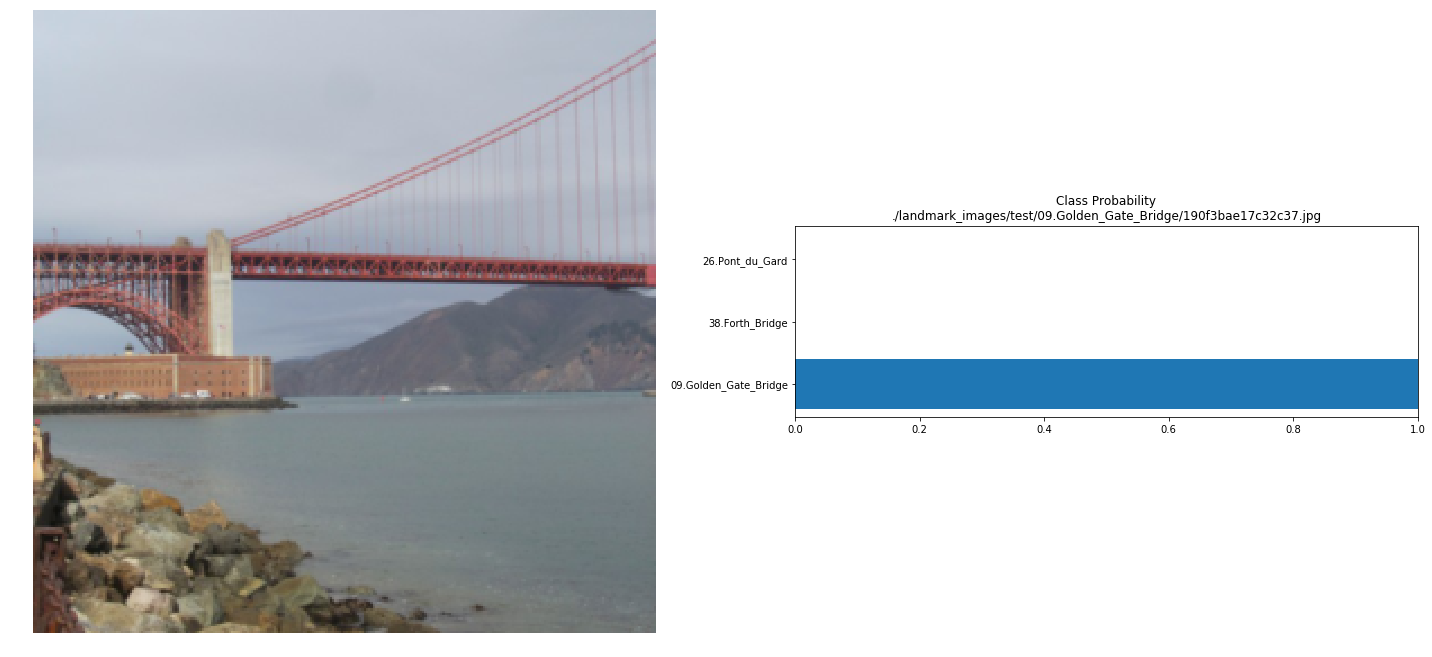

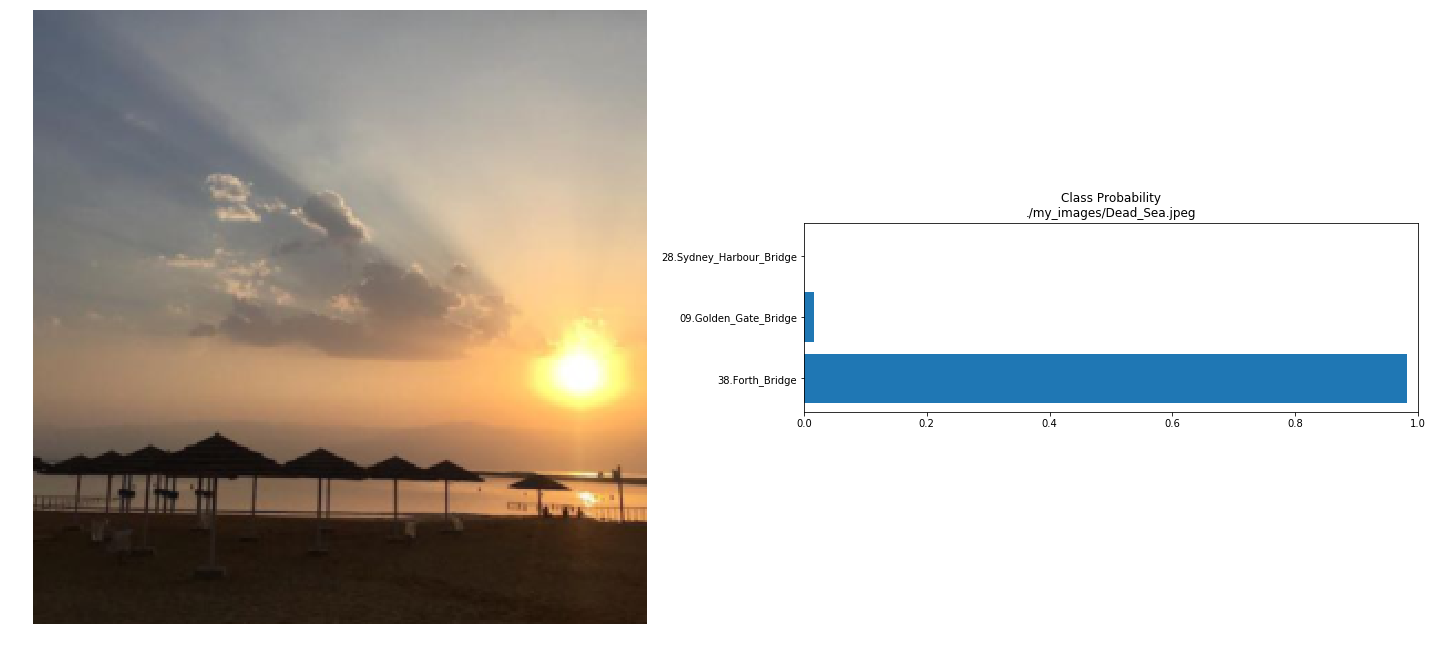

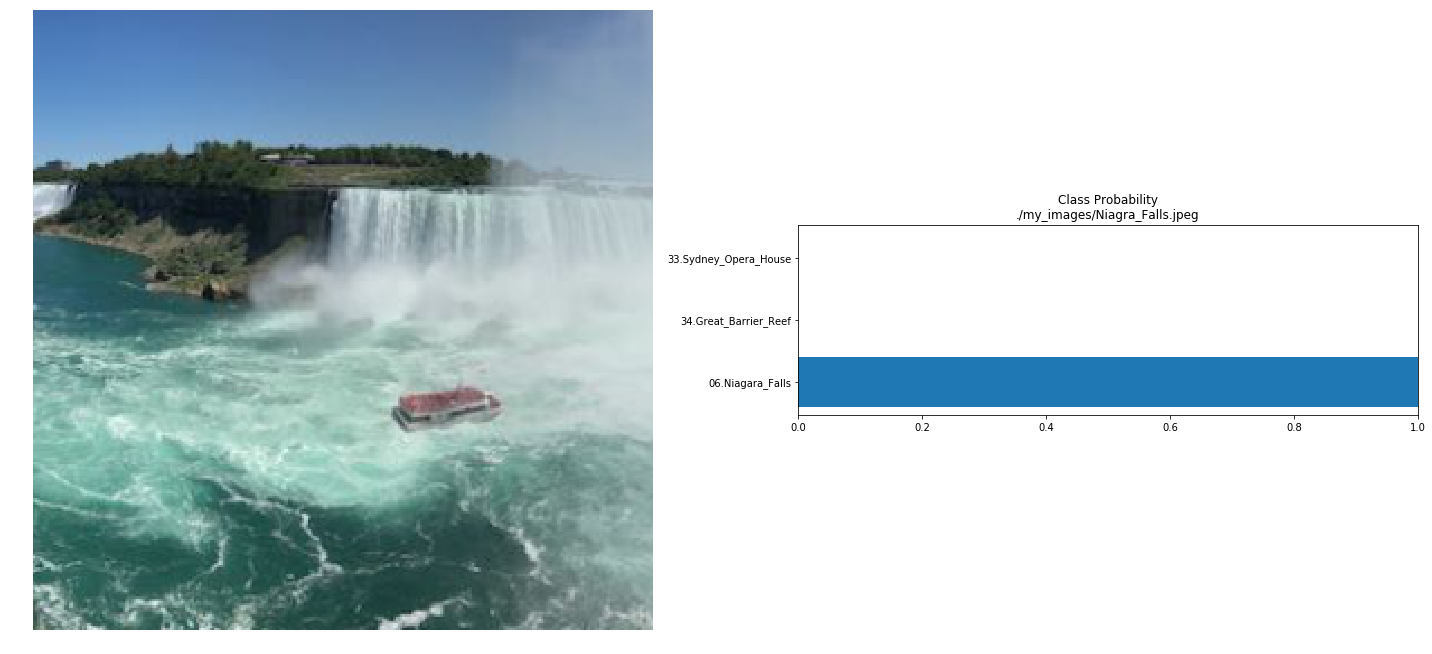

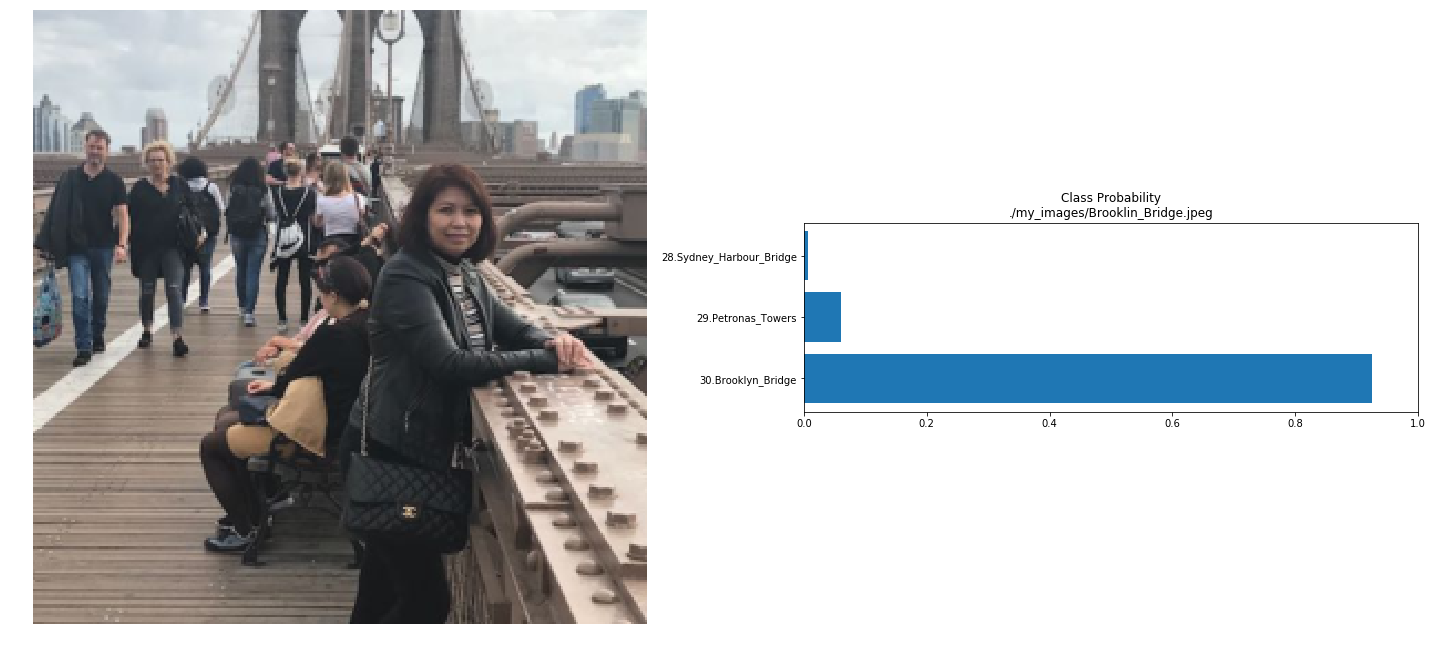

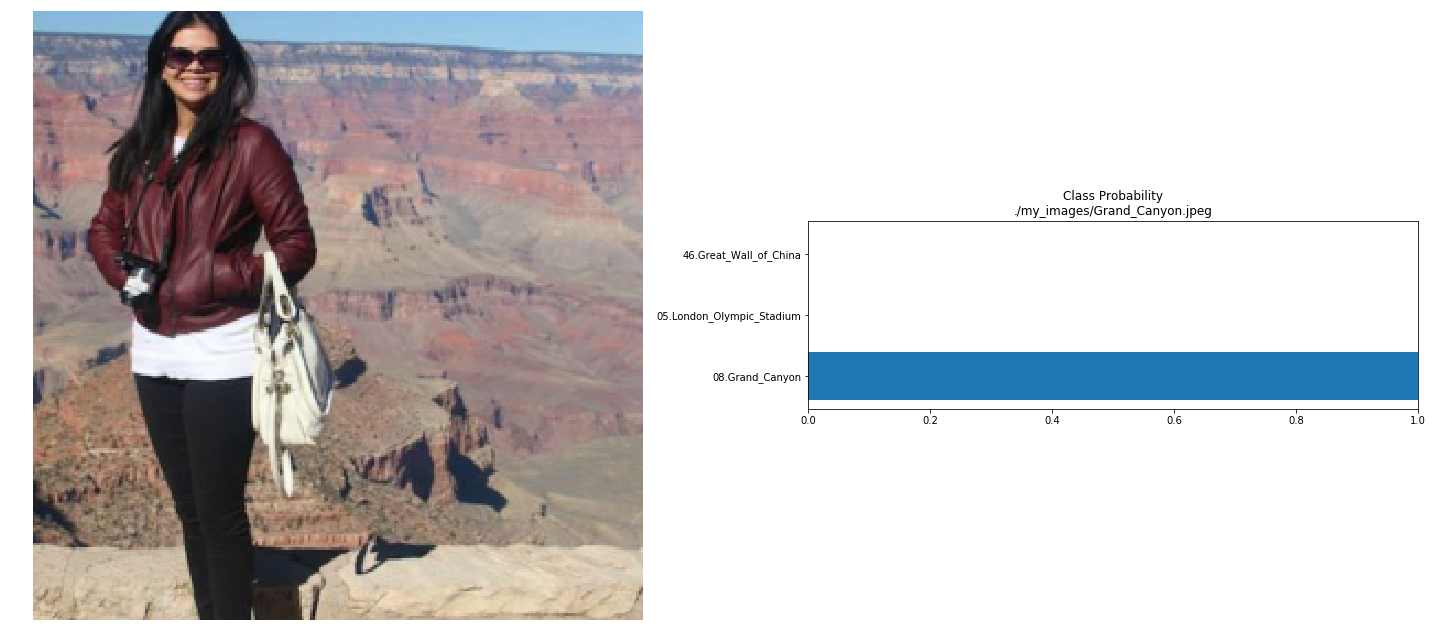

In [26]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('./landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')
suggest_locations('./my_images/Dead_Sea.jpeg')
suggest_locations('./my_images/Niagra_Falls.jpeg')
suggest_locations('./my_images/Brooklin_Bridge.jpeg')
suggest_locations('./my_images/Grand_Canyon.jpeg')